# Iteration 4_INFOSYS 722  
yzhb363 Emma

- This part starts from Data Preparation of Iteration 4
- I will number each relevant cell as answers
- please run **all cells** at the same time, since all packages are imported at the begining

In [3]:
import findspark
findspark.init('/home/ubuntu/spark-2.1.1-bin-hadoop2.7')
import pyspark
from pyspark.sql import SparkSession
from pyspark.sql import Row
from pyspark.sql.functions import col

spark = SparkSession.builder.appName('iteration4').getOrCreate()

In [4]:
# Import pandas.
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

In [ ]:
# Import ml algorithm
from pyspark.ml.classification import LogisticRegression
from pyspark.ml.classification import NaiveBayes
from pyspark.ml.evaluation import MulticlassClassificationEvaluator

In [5]:
# Import dataset 
dataFrame = spark.read.csv('Dataset/data.csv',header=True,inferSchema=True)

In [6]:
# Show the dataset
pd.DataFrame(dataFrame.take(20), columns=dataFrame.columns)

,ANZSOCGroup,MapDetailName,Region,NumberofVictimisations,NumberofRecords,OccurrenceDayOfWeek,Weapon,YearMonth
0,AggravatedSexualAssault,HillcrestWest.,WaikatoRegion,1,1,UNKNOWN,NotApplicable,1/07/14
1,Non-AggravatedSexualAssault,TeAwamutuCentral.,WaikatoRegion,1,1,Sun,NotApplicable,1/07/14
2,AggravatedSexualAssault,TotaraHeights.,AucklandRegion,1,1,Tue,NotStated,1/07/14
3,AggravatedSexualAssault,FlaxmereEast.,Hawke'sBayRegion,1,1,Sun,NotStated,1/07/14
4,AggravatedSexualAssault,Wairoa.,Hawke'sBayRegion,1,1,UNKNOWN,NotStated,1/07/14
5,AggravatedSexualAssault,Wairoa.,Hawke'sBayRegion,1,1,UNKNOWN,NotStated,1/07/14
6,AggravatedSexualAssault,Brentwood.,WellingtonRegion,1,1,UNKNOWN,NotStated,1/07/14
7,AggravatedSexualAssault,GlenEdenEast.,AucklandRegion,1,1,Mon,NotStated,1/07/14
8,AggravatedSexualAssault,GraftonEast.,AucklandRegion,1,1,Mon,NotStated,1/07/14
9,AggravatedSexualAssault,PukekoheNorth.,AucklandRegion,1,1,Wed,NotApplicable,1/09/14


## 2.3 Data Exporation

In [7]:
# Computer summary of the data
dataFrame.describe().show()

# Number of AggrabatedSexualAssault report
aggSexAssuaultTable = dataFrame[dataFrame.ANZSOCGroup.isin("AggravatedSexualAssault")]
print('\n' + "Total of aggravatedSexualAssault reports:", aggSexAssuaultTable.count())

# Number of Non-AggravatedSexualAssault report
nonAggravatedSexualAssault = dataFrame[dataFrame.ANZSOCGroup.isin("Non-AggravatedSexualAssault")]
print('\n' + "Total of Non-AggravatedSexualAssault reports:", nonAggravatedSexualAssault.count())


+-------+--------------------+-------------+---------------+----------------------+---------------+-------------------+-----------+---------+
|summary|         ANZSOCGroup|MapDetailName|         Region|NumberofVictimisations|NumberofRecords|OccurrenceDayOfWeek|     Weapon|YearMonth|
+-------+--------------------+-------------+---------------+----------------------+---------------+-------------------+-----------+---------+
|  count|                8354|         7734|           7734|                  8354|           8354|               8354|       8354|     8354|
|   mean|                null|         null|           null|    0.9547522145080201|            1.0|               null|       null|     null|
| stddev|                null|         null|           null|      0.52938282883613|            0.0|               null|       null|     null|
|    min|AggravatedSexualA...|  AbbeyCaves.| AucklandRegion|                     0|              1|                Fri|   Bludgeon|  1/01/15|
|    m

## 3 Data  Preparation
### 3.2 To clean the data, issues must be made explicit, then explicitly resolved.

In [8]:
# Show orginal columns before cleaning
print("Total data columns before cleaning:", dataFrame.count())

Total data columns before cleaning: 8354


In [9]:
# Drop null values with their rows
droppedTable = dataFrame.na.drop()

In [10]:
# Drop rows with UNKOWN occurrenceDayofWeek
cleanTable = droppedTable.filter(~col('OccurrenceDayOfWeek').isin(['UNKNOWN']))

In [11]:
# Show columns after cleaning
print("Total data columns after cleaning:", cleanTable.count())

pd.DataFrame(cleanTable.take(20), columns=cleanTable.columns)

Total data columns after cleaning: 6057


,ANZSOCGroup,MapDetailName,Region,NumberofVictimisations,NumberofRecords,OccurrenceDayOfWeek,Weapon,YearMonth
0,Non-AggravatedSexualAssault,TeAwamutuCentral.,WaikatoRegion,1,1,Sun,NotApplicable,1/07/14
1,AggravatedSexualAssault,TotaraHeights.,AucklandRegion,1,1,Tue,NotStated,1/07/14
2,AggravatedSexualAssault,FlaxmereEast.,Hawke'sBayRegion,1,1,Sun,NotStated,1/07/14
3,AggravatedSexualAssault,GlenEdenEast.,AucklandRegion,1,1,Mon,NotStated,1/07/14
4,AggravatedSexualAssault,GraftonEast.,AucklandRegion,1,1,Mon,NotStated,1/07/14
5,AggravatedSexualAssault,PukekoheNorth.,AucklandRegion,1,1,Wed,NotApplicable,1/09/14
6,AggravatedSexualAssault,Wiri.,AucklandRegion,1,1,Sat,NotApplicable,1/09/14
7,AggravatedSexualAssault,StarlingPark.,AucklandRegion,1,1,Mon,NotApplicable,1/09/14
8,AggravatedSexualAssault,AucklandHarbourside.,AucklandRegion,1,1,Mon,NotApplicable,1/09/14
9,AggravatedSexualAssault,AucklandCentralWest.,AucklandRegion,1,1,Sat,NotStated,1/09/14


### 3.3 Data must be appropriately constructed through the creation of new features/variables, and/or data repositories/tables. 

In [12]:
from pyspark.sql.functions import format_number, col

# Sort table by offenceType
groupOffenceType = cleanTable.sort('ANZSOCGroup', ascending = True)

# Sort table by Region 
sortedTable = groupOffenceType.sort('Region',ascending = True)

In [13]:
# Take the first twenty rows of data, and visualise.
pd.DataFrame(sortedTable.take(20), columns=sortedTable.columns)

,ANZSOCGroup,MapDetailName,Region,NumberofVictimisations,NumberofRecords,OccurrenceDayOfWeek,Weapon,YearMonth
0,AggravatedSexualAssault,OtaraNorth.,AucklandRegion,2,1,Sun,NotApplicable,1/11/14
1,AggravatedSexualAssault,PointView.,AucklandRegion,1,1,Wed,NotApplicable,1/08/14
2,AggravatedSexualAssault,HaraniaWest.,AucklandRegion,1,1,Mon,NotStated,1/08/14
3,AggravatedSexualAssault,GlenEdenEast.,AucklandRegion,1,1,Mon,NotStated,1/07/14
4,AggravatedSexualAssault,OneTreeHillEast.,AucklandRegion,1,1,Thu,NotStated,1/11/14
5,AggravatedSexualAssault,GraftonEast.,AucklandRegion,1,1,Mon,NotStated,1/07/14
6,AggravatedSexualAssault,PukekoheNorth.,AucklandRegion,1,1,Wed,NotApplicable,1/09/14
7,AggravatedSexualAssault,Wiri.,AucklandRegion,1,1,Sat,NotApplicable,1/09/14
8,AggravatedSexualAssault,StarlingPark.,AucklandRegion,1,1,Mon,NotApplicable,1/09/14
9,AggravatedSexualAssault,Dannemora.,AucklandRegion,1,1,Sat,NotStated,1/08/14


In [14]:
# Visualize the data 
sortedTable.groupby('ANZSOCGroup').count().toPandas()

,ANZSOCGroup,count
0,AggravatedSexualAssault,4229
1,Non-AggravatedSexualAssault,1828


## 7 Data Mining
- Binomial Logistic Regression

In [15]:
# Import training data
sortedTable.printSchema()
print(sortedTable.columns)

root
 |-- ANZSOCGroup: string (nullable = true)
 |-- MapDetailName: string (nullable = true)
 |-- Region: string (nullable = true)
 |-- NumberofVictimisations: integer (nullable = true)
 |-- NumberofRecords: integer (nullable = true)
 |-- OccurrenceDayOfWeek: string (nullable = true)
 |-- Weapon: string (nullable = true)
 |-- YearMonth: string (nullable = true)

['ANZSOCGroup', 'MapDetailName', 'Region', 'NumberofVictimisations', 'NumberofRecords', 'OccurrenceDayOfWeek', 'Weapon', 'YearMonth']


In [16]:
# Import the relevant packages.
from pyspark.ml.feature import (VectorAssembler,VectorIndexer,OneHotEncoder,StringIndexer)

In [30]:
# Create a string indexer which converts every string into a number
# such as AggravtedSexAssualt = 0 and Non-AggravtedSexAssualt = 1.
# A number will be assigned to every category in the column.
# Set offencetype as label
offenceType_indexer = StringIndexer(inputCol='ANZSOCGroup',outputCol='label')
areaName_indexer = StringIndexer(inputCol='MapDetailName',outputCol='areaIndex')
region_indexer = StringIndexer(inputCol='Region',outputCol='regionIndex')
occurDay_indexer = StringIndexer(inputCol='OccurrenceDayOfWeek',outputCol='occurDayIndex')
weapon_indexer = StringIndexer(inputCol='Weapon',outputCol='weaponIndex')
yearMonth_indexer = StringIndexer(inputCol='YearMonth',outputCol='yearMonthIndex')


# Conver the various outputs into a single vector.
# Multiple columns are collapsed into one. 
areaName_encoder = OneHotEncoder(inputCol='areaIndex',outputCol='areaVec')
region_encoder = OneHotEncoder(inputCol='regionIndex',outputCol='regionVec')
occurDay_encoder = OneHotEncoder(inputCol='occurDayIndex',outputCol='occurDayVec')
weapon_encoder = OneHotEncoder(inputCol='weaponIndex',outputCol='weaponVec')
yearMonth_encoder = OneHotEncoder(inputCol='yearMonthIndex',outputCol='yearMonthVec')


# Use vector assembler to turn all of these columns into one column (named features).
assembler = VectorAssembler(inputCols=['areaVec','regionVec','occurDayVec',
                                       'weaponVec','yearMonthVec','NumberofVictimisations', 
                                       'NumberofRecords'], outputCol="features")


In [18]:
from pyspark.ml import Pipeline

# Go through each columns to pipeline
pipeline = Pipeline(stages=[areaName_indexer, region_indexer, occurDay_indexer, weapon_indexer, yearMonth_indexer, 
                            areaName_encoder, region_encoder, occurDay_encoder, weapon_encoder, yearMonth_encoder,
                            offenceType_indexer, assembler])

# Apply it to the data.
pipeline_model = pipeline.fit(sortedTable)

# Incorporate results into a new DataFrame.
pipe_df = pipeline_model.transform(sortedTable)

# Remove all variables other than features and label. 
pipe_df = pipe_df.select('label', 'features')

In [31]:
# Split data into train and test. 
train_data, test_data = pipe_df.randomSplit([0.7,0.3])
print("Training Dataset Count: " + str(train_data.count()))
print("Test Dataset Count: " + str(test_data.count()))

# Instantiate the model.
lr_model = LogisticRegression(featuresCol='features',labelCol='label')

# Fit the model.
lr_model = lr_model.fit(train_data)

# And evaluate the model using the test data.
results = lr_model.transform(test_data)

Training Dataset Count: 4277
Test Dataset Count: 1780


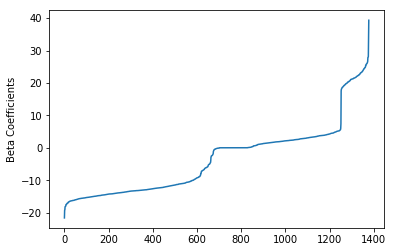

In [22]:
# Visualising the coefficients. Sort from lowest to highest.
beta = np.sort(lr_model.coefficients)

# Plot the data.
plt.plot(beta)

# Add a label to the data.
plt.ylabel('Beta Coefficients')

# Show the graph. 
plt.show()

- Naive Bayes  
**Naive Bayes classifiers are a family of simple probabilistic classifiers based on applying Bayes’ theorem with strong (naive) independence assumptions between the features. **

In [48]:
# Split data into train and test. 
naiBaTrain_data, naiBaTest_data = pipe_df.randomSplit([0.7,0.3])
print("Training Dataset Count: " + str(naiBaTrain_data.count()))
print("Test Dataset Count: " + str(naiBaTest_data.count()))

# create the trainer and set its parameters
nb = NaiveBayes(smoothing=1.0, modelType="multinomial")

# train the model
naiBaModel = nb.fit(naiBaTrain_data)

# select example rows to display.
predictions = naiBaModel.transform(naiBaTest_data)


pd.DataFrame(predictions.take(20))



# compute accuracy on the test set
evaluator = MulticlassClassificationEvaluator(labelCol="label", predictionCol="prediction",
                                              metricName="accuracy")
accuracy = evaluator.evaluate(predictions)
print("Test set accuracy = " + str(accuracy))



Training Dataset Count: 4234
Test Dataset Count: 1823
Test set accuracy = 0.689522764673615
